In [1]:
from IPython.display import Markdown, Latex
displaym = lambda markdown : display(Markdown(markdown))
from sklearn.cluster import AgglomerativeClustering
from spotifyUtil import get_spotify_client, plot_dendrogram
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from scipy.cluster import hierarchy
spotify = get_spotify_client()
import matplotlib.pyplot as plt
from scipy.stats import zscore
from datetime import datetime
import pandas as pd
import numpy as np

---
# Collect All My Playlists

In [18]:
my_playlists = []
offset = 0
append_playlists = spotify.current_user_playlists(offset=offset)["items"]
while len(append_playlists) > 0:
    my_playlists += append_playlists
    offset += len(append_playlists)
    append_playlists = spotify.current_user_playlists(offset=offset)["items"]
displaym("""
## My Playlists  
Collected **{}** playlists
""".format(
    len(my_playlists)
))


## My Playlists  
Collected **48** playlists


# Union **WoofBeats&trade;** Playlists and Add Track Features

In [12]:
WoofBeats_playlists = [
    p for p in my_playlists 
    if "WoofBeats" in p["name"] and "20" in p["name"]
]

# get tracks
for playlist in WoofBeats_playlists:
    playlist.update({
        "tracks":spotify.playlist_tracks(playlist["id"]) 
    })

displaym(
"""
## **WoofBeats&trade;** Playlists
 - {}
---
""".format(
    " \n- ".join([
        "{}: **{}** songs".format(
            playlist["name"], 
            len(playlist["tracks"]["items"])
        ) 
        for playlist in WoofBeats_playlists
    ])
))


## **WoofBeats&trade;** Playlists
 - WoofBeats-2021-12: **26** songs 
- WoofBeats-2021-11: **23** songs 
- WoofBeats-2021-10: **27** songs 
- WoofBeats-2021-09: **34** songs 
- WoofBeats-2021-08: **29** songs 
- WoofBeats-2021-07: **30** songs 
- WoofBeats-2021-06: **50** songs 
- WoofBeats-2021-05: **37** songs 
- WoofBeats-2021-04: **50** songs 
- WoofBeats-2021-03: **38** songs 
- WoofBeats-2021-02: **45** songs 
- WoofBeats-2021-01: **56** songs 
- WoofBeats-2020-12: **46** songs
---


## Track Features

In [4]:
WoofBeats_tracks = [
    {
        "playlist_name": playlist["name"],
        "playlist_id": playlist["id"],
        "added_by": track["added_by"]["id"],
        **track["track"]
    }
    for playlist in WoofBeats_playlists
    for track in playlist["tracks"]["items"]
]

WoofBeats_tracks = [
    {
        "track_id" : track["id"],
        "track_name" :track["name"],
        "track_duration_ms" : track["duration_ms"],
        "track_popularity" : track["popularity"],
        "track_explicit" : track["explicit"],
        **{
            "track_" + key:value 
            for key, value in spotify.audio_features([track["id"]])[0].items()
        },
        "album_name" : track["album"]["name"],
        "album_release_timestamp" : pd.to_datetime(track["album"]["release_date"]).timestamp(),
        "album_id" : track["album"]["id"],
        "artist_id" : track["artists"][0]["id"],
        "artist_name" : track["artists"][0]["name"],
        "playlist_name" : track["playlist_name"],
        "playlist_id" : track["playlist_id"],
        "added_by": track["added_by"]
    }
    for track in WoofBeats_tracks
]

added_by_map = {
    "12167264510" : "Dakota",
    "12145760918" : "Dan"
}

for track in WoofBeats_tracks:
    added_by = track["added_by"]
    track["added_by"] = added_by_map[added_by] if added_by in added_by_map else added_by

for track in WoofBeats_tracks:
    for key in [
        "track_type",
        "track_uri",
        "track_track_href",
        "track_analysis_url",
        ]:
        del track[key]
        
WoofBeats_df = pd.DataFrame(WoofBeats_tracks)
display(WoofBeats_df.info())
display(WoofBeats_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   track_id                 491 non-null    object 
 1   track_name               491 non-null    object 
 2   track_duration_ms        491 non-null    int64  
 3   track_popularity         491 non-null    int64  
 4   track_explicit           491 non-null    bool   
 5   track_danceability       491 non-null    float64
 6   track_energy             491 non-null    float64
 7   track_key                491 non-null    int64  
 8   track_loudness           491 non-null    float64
 9   track_mode               491 non-null    int64  
 10  track_speechiness        491 non-null    float64
 11  track_acousticness       491 non-null    float64
 12  track_instrumentalness   491 non-null    float64
 13  track_liveness           491 non-null    float64
 14  track_valence            4

None

,track_id,track_name,track_duration_ms,track_popularity,track_explicit,track_danceability,track_energy,track_key,track_loudness,track_mode,...,track_tempo,track_time_signature,album_name,album_release_timestamp,album_id,artist_id,artist_name,playlist_name,playlist_id,added_by
0,7Fk0zNC7vGdoDwePPgByKh,Peaches N Cream (feat. Charlie Wilson),284213,43,False,0.830,0.722,0,-6.099,1,...,109.987,4,Peaches N Cream (feat. Charlie Wilson),1.425946e+09,0tKHgjptFpCMWQyKrwThXF,7hJcb9fa4alzcOq3EaNPoG,Snoop Dogg,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,davidmimorton
1,32YOyb6WzKcHHWOPNBndvL,the astronaut,185078,35,False,0.559,0.343,7,-9.155,1,...,166.034,4,the astronaut,1.617667e+09,2vZMnfL7DLYTIGiz3piGn7,7BexBpZwJEohkHnOeuXDoi,Ray Goren,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,Dan
2,0ssRH9I8P7X7tawJQiIhzE,1993 (feat. Little Ricky ZR3),159832,53,True,0.701,0.676,9,-5.873,1,...,105.041,4,Ugly is Beautiful,1.594944e+09,1HmWQo43Gt8BR2dylfv3o4,6TLwD7HPWuiOzvXEa3oCNe,Oliver Tree,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,Dan
3,2KUyYDas5sAAulThIiZBO5,Brass,151380,41,True,0.775,0.890,2,-4.574,0,...,142.948,4,Brass,1.577059e+09,1ZRprAbchzdVCZZnH9BaDQ,22KyrgRdE2K6aB5wtZls3c,AG Club,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,Dakota
4,3sN85u5M7FoMmHa8E2aViO,Heybb!,148608,59,False,0.654,0.972,6,-2.872,0,...,117.009,4,Heybb!,1.571270e+09,5CfgvNG8Y0ZGXAx3rNvjC8,2jbd7OqeJJd1hz81vOXwwW,binki,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,Dakota



### Feature Summary: **track duration ms**  
 - Mean: 219453.878
 - Std: 65114.864
 - Range: 98275 - 662773
 - Width: 564498

        

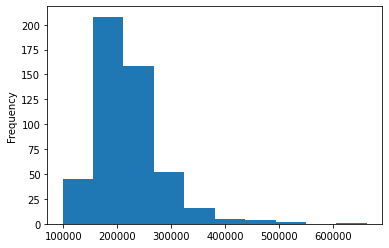

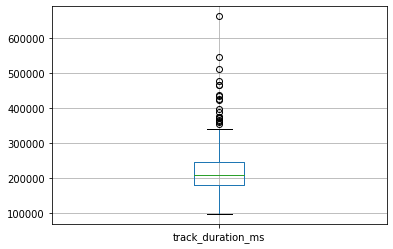


### Feature Summary: **track popularity**  
 - Mean: 47.208
 - Std: 19.827
 - Range: 0 - 83
 - Width: 83

        

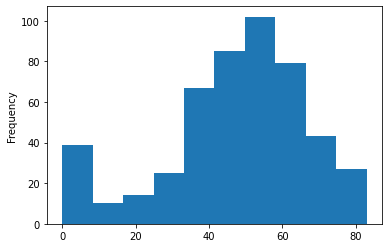

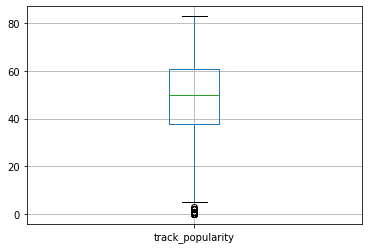


### Feature Summary: **track danceability**  
 - Mean: 0.637
 - Std: 0.145
 - Range: 0.152 - 0.964
 - Width: 0.812

        

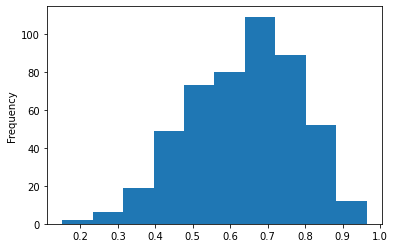

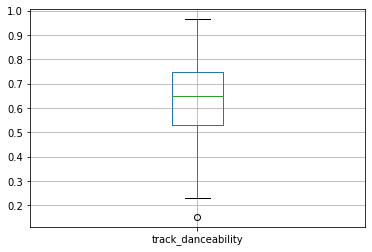


### Feature Summary: **track energy**  
 - Mean: 0.692
 - Std: 0.154
 - Range: 0.221 - 0.981
 - Width: 0.76

        

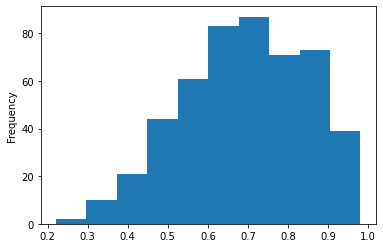

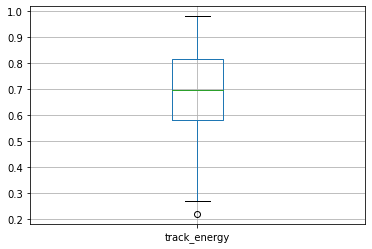


### Feature Summary: **track key**  
 - Mean: 5.403
 - Std: 3.49
 - Range: 0 - 11
 - Width: 11

        

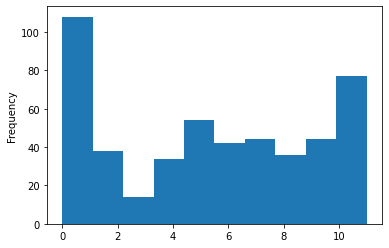

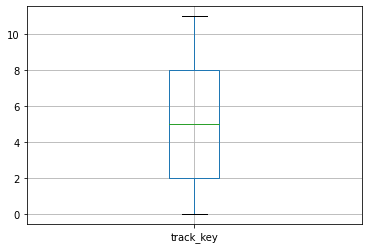


### Feature Summary: **track loudness**  
 - Mean: -6.421
 - Std: 2.199
 - Range: -14.431 - -0.868
 - Width: 13.563

        

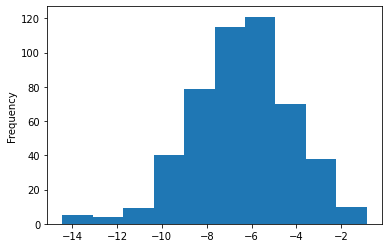

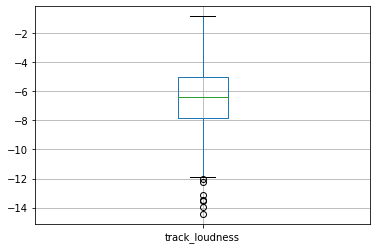


### Feature Summary: **track mode**  
 - Mean: 0.564
 - Std: 0.496
 - Range: 0 - 1
 - Width: 1

        

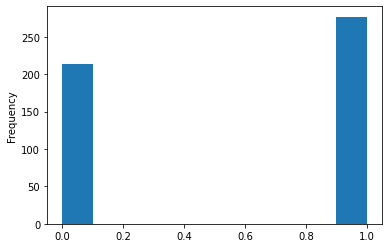

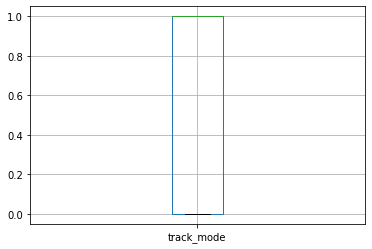


### Feature Summary: **track speechiness**  
 - Mean: 0.155
 - Std: 0.131
 - Range: 0.026 - 0.902
 - Width: 0.876

        

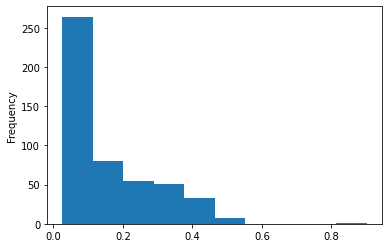

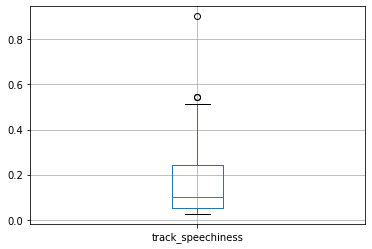


### Feature Summary: **track acousticness**  
 - Mean: 0.172
 - Std: 0.2
 - Range: 0.0 - 0.923
 - Width: 0.923

        

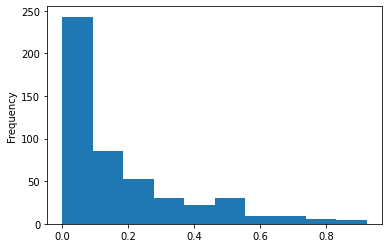

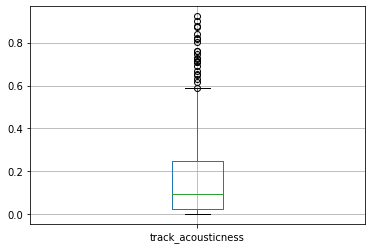


### Feature Summary: **track instrumentalness**  
 - Mean: 0.038
 - Std: 0.138
 - Range: 0.0 - 0.911
 - Width: 0.911

        

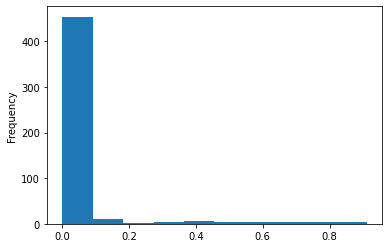

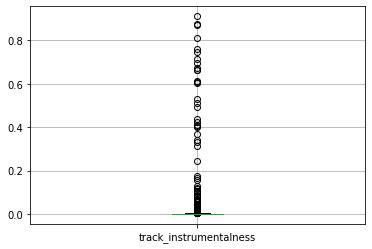


### Feature Summary: **track liveness**  
 - Mean: 0.22
 - Std: 0.165
 - Range: 0.026 - 0.821
 - Width: 0.795

        

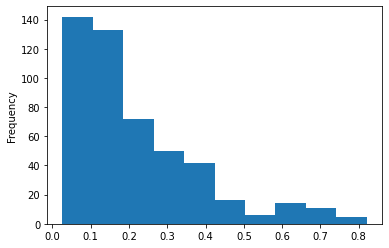

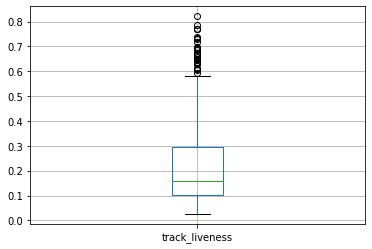


### Feature Summary: **track valence**  
 - Mean: 0.521
 - Std: 0.22
 - Range: 0.037 - 0.981
 - Width: 0.944

        

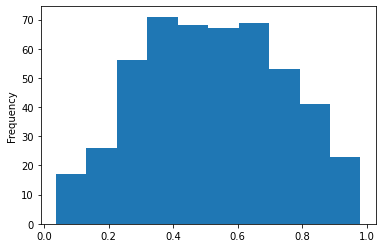

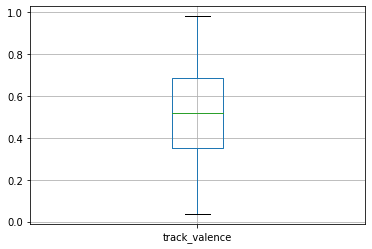


### Feature Summary: **track tempo**  
 - Mean: 119.347
 - Std: 31.009
 - Range: 64.474 - 206.68
 - Width: 142.206

        

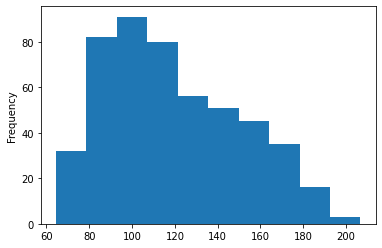

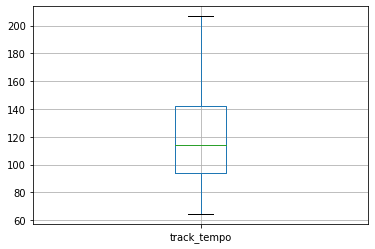


### Feature Summary: **track time signature**  
 - Mean: 3.974
 - Std: 0.258
 - Range: 1 - 5
 - Width: 4

        

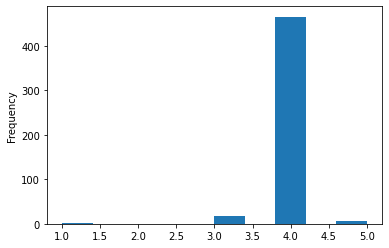

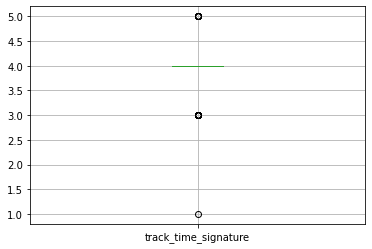


### Feature Summary: **album release timestamp**  
 - Mean: 1434715463.951
 - Std: 304560950.88
 - Range: -347155200.0 - 1637539200.0
 - Width: 1984694400.0

        

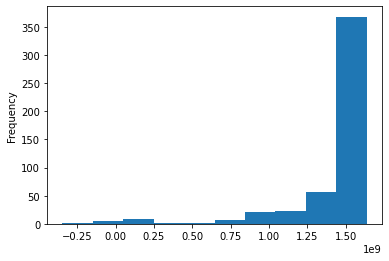

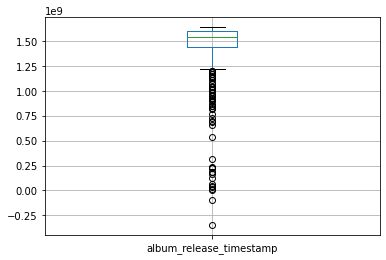

In [5]:
plt.rcParams["figure.figsize"] = (8,4)
for col in WoofBeats_df.columns:
    if type(WoofBeats_df[col][0]) in [np.float64, np.int64]:
        displaym("""
### Feature Summary: **{}**  
 - Mean: {}
 - Std: {}
 - Range: {} - {}
 - Width: {}

        """.format(
            col.replace("_"," "),
            round(WoofBeats_df[col].mean(),3),
            round(WoofBeats_df[col].std(),3),
            round(min(WoofBeats_df[col]),3),
            round(max(WoofBeats_df[col]),3),
            round(max(WoofBeats_df[col]) - min(WoofBeats_df[col]),3)
        ))
        WoofBeats_df[col].plot.hist()
        plt.show()
        WoofBeats_df.boxplot(col)
        plt.show()


### Feature Summary: **album name**  
 - Most Common: Donda
 - Least Common: x (Deluxe Edition)
    

,0
album_name,
Donda,4
Gooey,3
Ugly is Beautiful,3
The Tragedian's Decoupage,3
Complicate Your Life with Violence,3



### Feature Summary: **artist name**  
 - Most Common: Yung Gravy
 - Least Common: ¿Téo?
    

,0
artist_name,
Yung Gravy,13
A$AP Rocky,9
Kanye West,8
Mac Miller,7
$uicideboy$,6



### Feature Summary: **playlist name**  
 - Most Common: WoofBeats-2021-01
 - Least Common: WoofBeats-2021-11
    

,0
playlist_name,
WoofBeats-2021-01,56
WoofBeats-2021-04,50
WoofBeats-2021-06,50
WoofBeats-2020-12,46
WoofBeats-2021-02,45


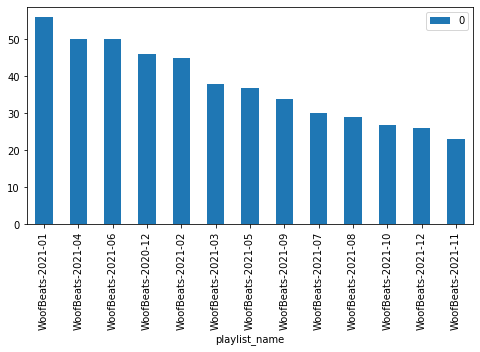


### Feature Summary: **added by**  
 - Most Common: davidmimorton
 - Least Common: beet1eman
    

,0
added_by,
davidmimorton,181
Dakota,157
Dan,149
1243264703,2
beet1eman,2


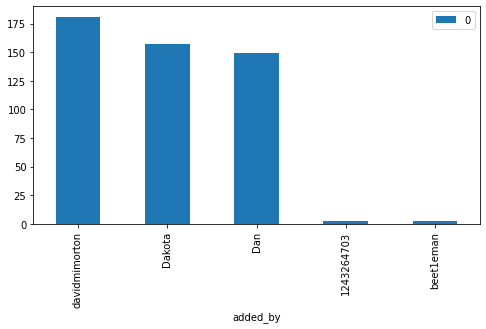

In [6]:
plt.rcParams["figure.figsize"] = (8,4)

categorical_features = [
    "album_name",
    "artist_name",
    "playlist_name",
    "added_by"
]

for col in categorical_features:
    sorted_categories = WoofBeats_df[[col]].groupby(col) \
            .size() \
            .sort_values(ascending=False) \
            .reset_index(col) \
            .set_index(col)
    
    displaym("""
### Feature Summary: **{}**  
 - Most Common: {}
 - Least Common: {}
    """.format(
        col.replace("_"," "),
        sorted_categories.index[0],
        sorted_categories.index[len(sorted_categories.index)-1]
    ))
    display(sorted_categories.head())
    if col in ["added_by", "playlist_name"]:
        sorted_categories.plot.bar()
        plt.show()
    


# Standardize Numerical Features and Apply PCA Dimension Reduction


## PCA Explained Variance Ratios Chart  
- **Method**  
    - Include components that explain **>5%** of the variance  
- **Result**
    - Used **10** principal components  
    - Explained Variance Ratios (%): 13.5, 12.1, 8.9, 8.6, 7.6, 6.5, 6.5, 5.7, 5.5, 5.3, 4.7, 4.4, 3.3, 3.0, 2.8, 1.5  


<AxesSubplot:>

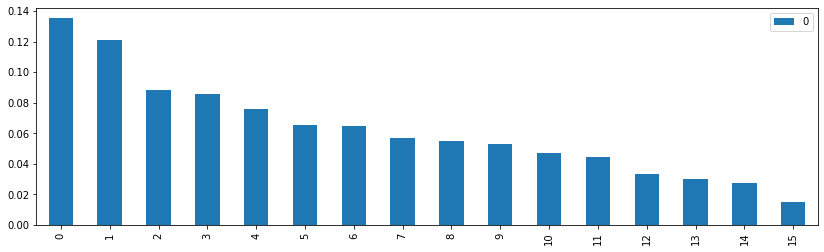

In [47]:
plt.rcParams["figure.figsize"] = (14,4)

numerical_features = [
    "track_duration_ms",
    "track_popularity",
    "track_explicit",
    "track_danceability",
    "track_energy",
    "track_key",
    "track_loudness",
    "track_mode",
    "track_speechiness",
    "track_acousticness",
    "track_instrumentalness",
    "track_liveness",
    "track_valence",
    "track_tempo",
    "track_time_signature",
    "album_release_timestamp"
] 
    
standardized_numerical_features = WoofBeats_df[numerical_features].apply(zscore)

pca = PCA(n_components=standardized_numerical_features.shape[1])
pca.fit(standardized_numerical_features)

reduced_numerical_features = pd.DataFrame(
    pca.transform(standardized_numerical_features),
    index=WoofBeats_df["track_id"]
)[[i for i, v in enumerate(pca.explained_variance_ratio_) if v > 0.05]]
displaym("""
## PCA Explained Variance Ratios Chart  
- **Method**  
    - Include components that explain **>5%** of the variance  
- **Result**
    - Used **{}** principal components  
    - Explained Variance Ratios (%): {}  
""".format(
    len(reduced_numerical_features.columns),
    ", ".join([str(round(e*100,1)) for e in pca.explained_variance_ratio_])
))
pd.DataFrame(pca.explained_variance_ratio_).plot.bar()

# Apply Clustering and Create **theRes/*.v001** Playlists
## Hierarchical Clustering Dendrogram 
- **Method**
    - Generate **6** hierarchical clusters from the PCA transformed features

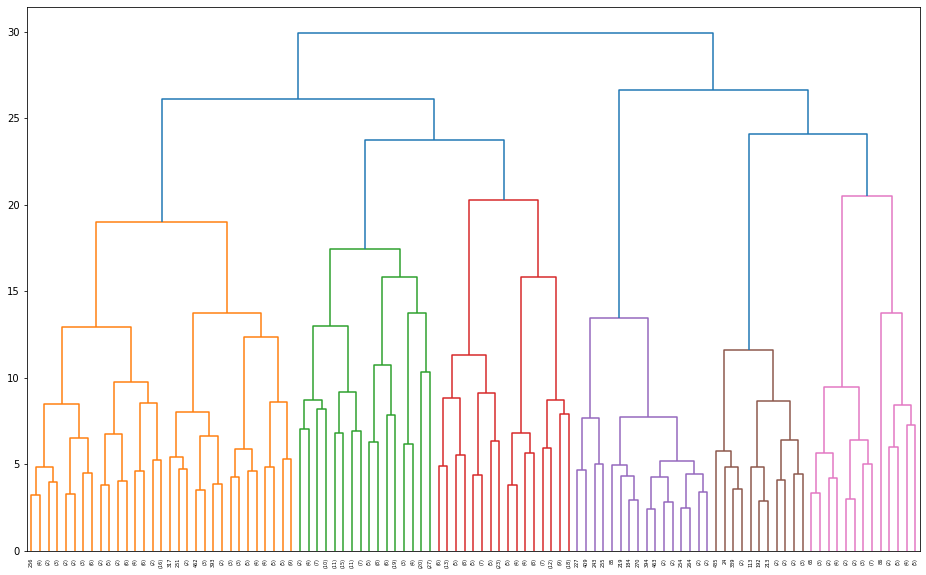

In [8]:
plt.rcParams["figure.figsize"] = (16,10)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(reduced_numerical_features)
plot_dendrogram(model, truncate_mode="level", p=6)
model = AgglomerativeClustering(n_clusters=6)
model = model.fit(reduced_numerical_features)

## Add Cluster Labels

In [9]:
theRes_playlist = pd.DataFrame(
    model.labels_,
    columns = ["theRes_playlist_id"]
)
theRes_playlist = pd.concat(
    [theRes_playlist, WoofBeats_df],
    axis=1
)
theRes_playlist[theRes_playlist["theRes_playlist_id"]==1]

,theRes_playlist_id,track_id,track_name,track_duration_ms,track_popularity,track_explicit,track_danceability,track_energy,track_key,track_loudness,...,track_tempo,track_time_signature,album_name,album_release_timestamp,album_id,artist_id,artist_name,playlist_name,playlist_id,added_by
7,1,4koUus4S93dvJTG1y2REpO,Pistol Packin',133451,45,True,0.877,0.633,8,-7.827,...,144.067,4,Roommates,1.576800e+09,1ltF2yYtR3S6GbRJaZNSNp,3XdU4Dq9V7PluphM2tjhIE,Henry AZ,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,davidmimorton
8,1,64N9iPP5DxkAjNkmSGdg8h,Roller Disco 1980,204520,27,False,0.778,0.668,6,-5.397,...,99.999,4,Time Machine,1.579824e+09,0FFubmrHvePJdLgvKaVLIq,4JhjlqgMbd4RlrT81VoTIF,The Geek x Vrv,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,davidmimorton
13,1,6avIhKyw4XLjz3w1Q8pBIa,ozymandias,225755,34,False,0.730,0.437,4,-9.614,...,119.979,4,oRANGE.,1.603238e+09,0A6A8b1qnY9WApLW05Vohf,2EOIjdzbFGRM87IvJU34JJ,Stop Light Observations,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,Dan
20,1,365TSrFPqM66giaxJuafR3,Shine A Little Light,196777,57,False,0.440,0.719,8,-6.645,...,111.398,4,"""Let's Rock""",1.561680e+09,0aA9rYw8PEv9G7tVIJ9dKg,7mnBLXK823vNxN3UWB7Gfz,The Black Keys,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,Dan
21,1,2b0G006xcIUoqvRDDaCT8E,July,207587,54,False,0.607,0.658,6,-5.552,...,99.983,4,Feels Like We’ve Been Here Before,1.602806e+09,3oDmsU4EhxfrPOBYycOyEO,3pT3KTodKJRyqpxoXINfQh,Betcha,WoofBeats-2021-12,4Wj5LF1wo57BP6Fk2Itzk9,Dan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,1,0JzPnwc3eDdyBeReXFLgXr,Look Easy,165219,51,True,0.718,0.637,1,-9.962,...,108.023,4,Look Easy,1.594339e+09,0XCbNyUbT3873z30JAwkbi,6qgnBH6iDM91ipVXv28OMu,KAYTRANADA,WoofBeats-2020-12,26ytCXO4GPGK6MEr3uZojZ,davidmimorton
481,1,3Ka76BnYHotgd40hw9bCmy,Are You Dumm?,186000,41,True,0.689,0.797,6,-1.374,...,140.042,4,Are You Dumm?,1.558224e+09,64km14wDsYdGhIjEtr5EFl,3yWkGucNPWM01EylvM8Ng3,Flmmboiint Frdii,WoofBeats-2020-12,26ytCXO4GPGK6MEr3uZojZ,Dakota
482,1,2NSHs7fnTlqosMNy72P7Mb,Fast Talk,259947,0,False,0.603,0.502,9,-7.732,...,69.987,4,Fast Talk,1.535069e+09,3SMoItGjCanLw0iCHTeffs,648kpaANsUr1HABoE4mkPw,Houses,WoofBeats-2020-12,26ytCXO4GPGK6MEr3uZojZ,Dan
484,1,531MBHrtGF6nAkK4zUafi9,Mutual Butterflies,183875,62,True,0.616,0.649,3,-5.133,...,78.131,4,august,1.535674e+09,7h1xc7a0GqmwkzOu29YbjD,5YHM0i7v5TqqibZhS0YiuX,Ryan Trey,WoofBeats-2020-12,26ytCXO4GPGK6MEr3uZojZ,Dakota


## Create Playlist for each Cluster Label

In [11]:
current_user_id = spotify.current_user()["id"]
for playlist_id in set(theRes_playlist["theRes_playlist_id"]):
    new_playlist = spotify.user_playlist_create(
        current_user_id,
        "theRes/cluster{}.v001".format(playlist_id)
    )
    track_ids = list(theRes_playlist[theRes_playlist["theRes_playlist_id"]==playlist_id]["track_id"])

    displaym("""
---
Created Playlist: **{}**   
Song Count: **{}**
---
    """.format(
        new_playlist["name"],
        len(track_ids)
    ))
    uploaded_tracks_count = 0
    page_size = 100
    while uploaded_tracks_count<=len(track_ids):
        end_of_page = min(len(track_ids),uploaded_tracks_count + page_size)
        spotify.playlist_add_items(
            new_playlist["id"],
            track_ids[uploaded_tracks_count:end_of_page]
        )
        uploaded_tracks_count += page_size


---
Created Playlist: **theRes/cluster0.v001**   
Song Count: **41**
---
    


---
Created Playlist: **theRes/cluster1.v001**   
Song Count: **139**
---
    


---
Created Playlist: **theRes/cluster2.v001**   
Song Count: **159**
---
    


---
Created Playlist: **theRes/cluster3.v001**   
Song Count: **115**
---
    


---
Created Playlist: **theRes/cluster4.v001**   
Song Count: **17**
---
    


---
Created Playlist: **theRes/cluster5.v001**   
Song Count: **20**
---
    